# A survey on existing time series with holes in Data Commons:

In this notebook, we're focused on time series and only those that have missing values in them. A missing value happens when there is no data for an observed date. Missing values might happen in the steps of a data collection. For some data analysis or machine learning purposes, we should impute the missing values before using the data set. In this tutorial, we go through random statistical variables that are available in Data Commons. We explore the time series and impute their missing values using Pandas and imputation methods that this package provides. 

In [33]:
from google.colab import auth
auth.authenticate_user()

# Import the required libraries
import pandas as pd
import numpy as np
import random

!pip install datacommons --upgrade --quiet
import datacommons as dc
import datacommons_pandas as dcpd

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import a scoring metric to compare methods
from sklearn.metrics import r2_score
%matplotlib inline

from google.cloud import bigquery
project_id = "google.com:datcom-store-dev"
client = bigquery.Client(project=project_id)

import numpy as np

print("Welcome to the Missing Data Imputation Tutorial")


Welcome to the Missing Data Imputation Tutorial


# Sample random statistical variables:

In the following code we run about 300 queries to data commons and among them we store and plot those with multiple holes. We use function **`select_random_statvars(sample_size, plot_flag, print_flag)`**. You can alter the plot_flag and print_flag to hide plots and print log respectively.

number of valid samples:  6 ['Count_Death_CertainInfectiousParasiticDiseases_Female', 'WagesTotal_Worker_NAICSInformation', 'Count_Establishment_PrivatelyOwnedEstablishment_NAICSProfessionalScientificTechnicalServices', 'Count_Worker_PrivatelyOwnedEstablishment_NAICSEducationalServices', 'Count_Death_EndocrineNutritionalMetabolicDiseases_Female', 'WagesTotal_Worker_PrivatelyOwnedEstablishment_NAICSWholesaleTrade']


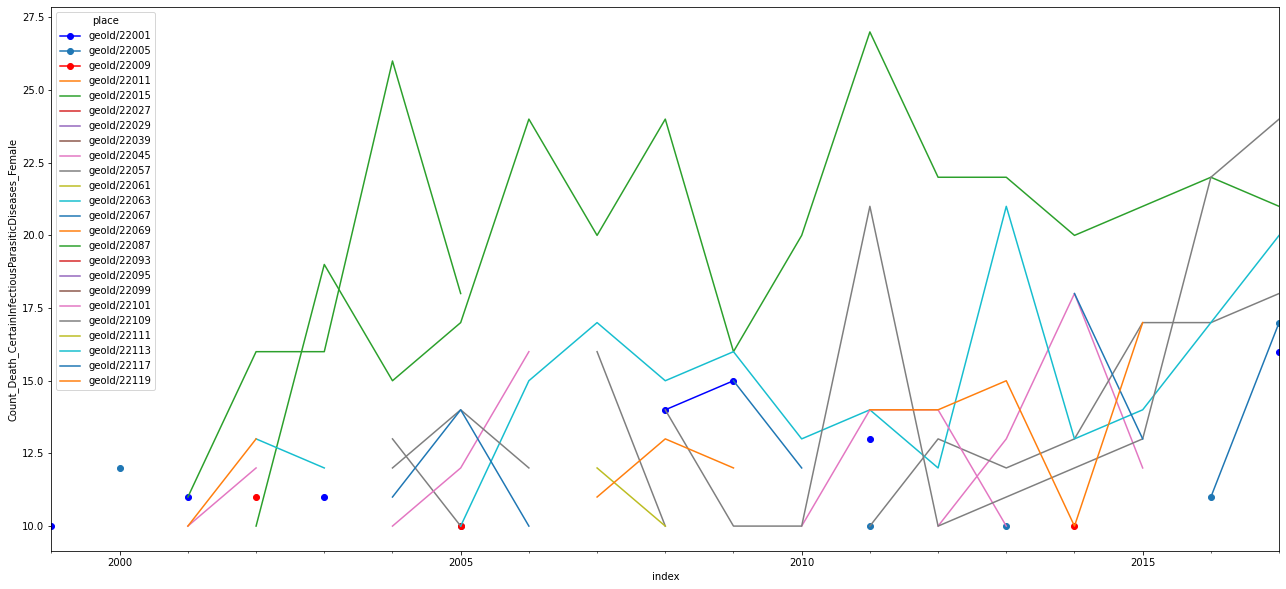

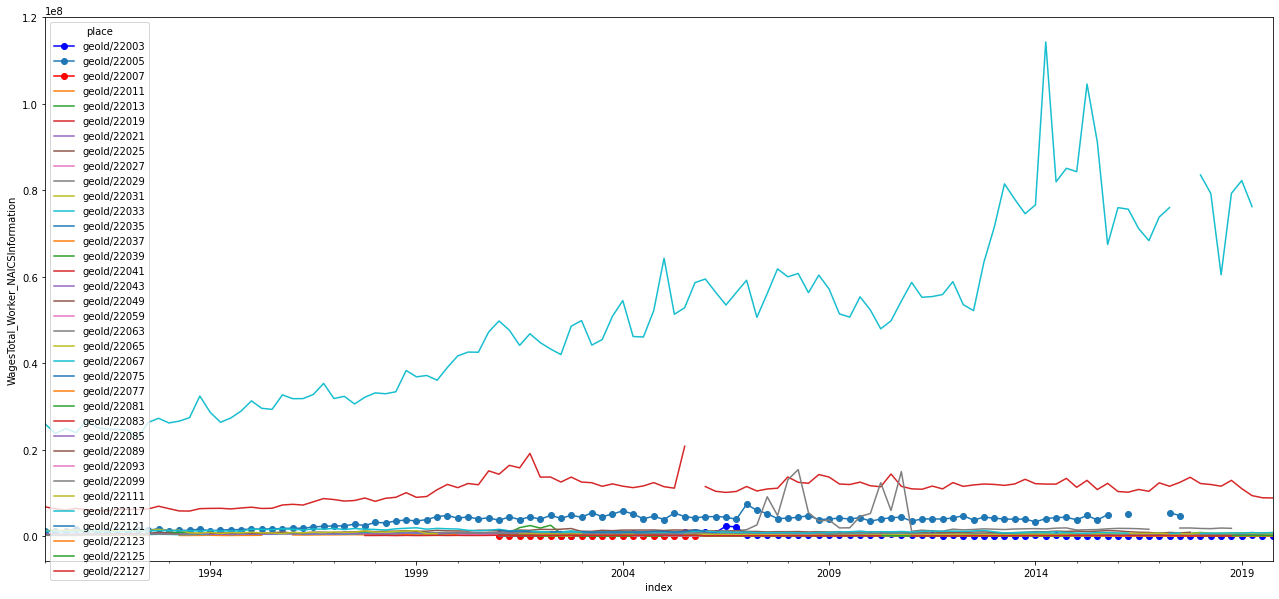

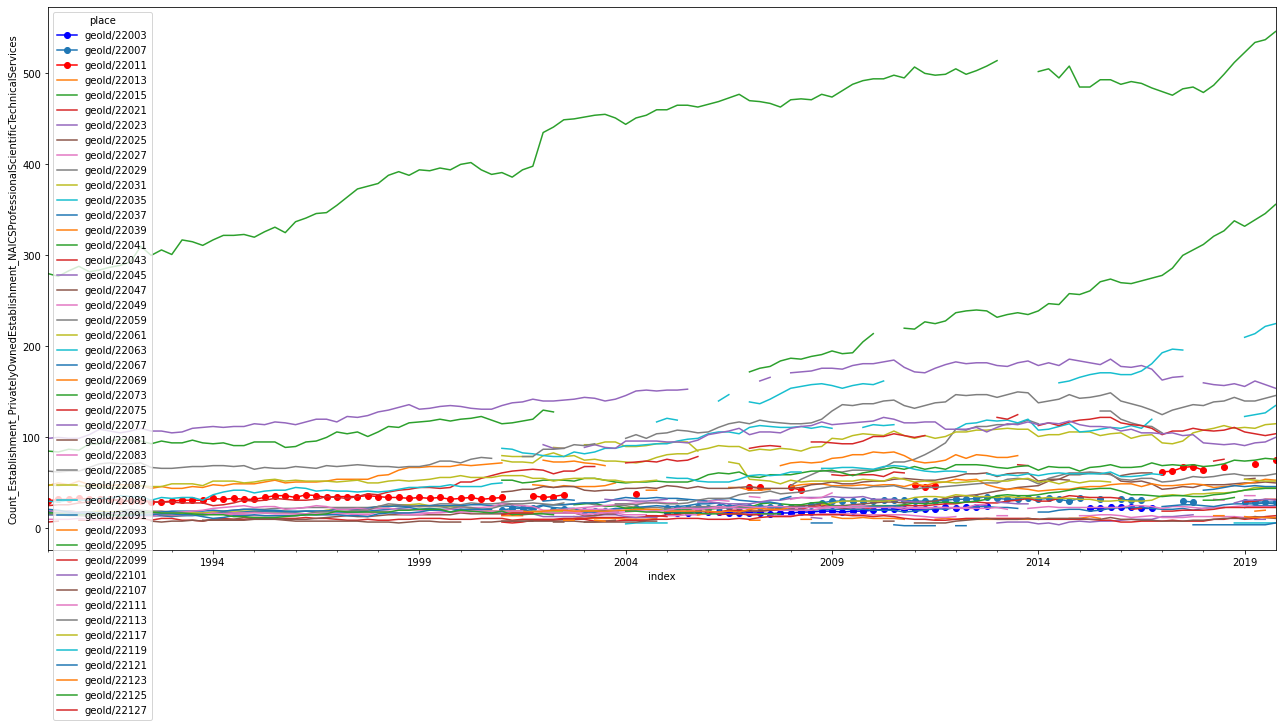

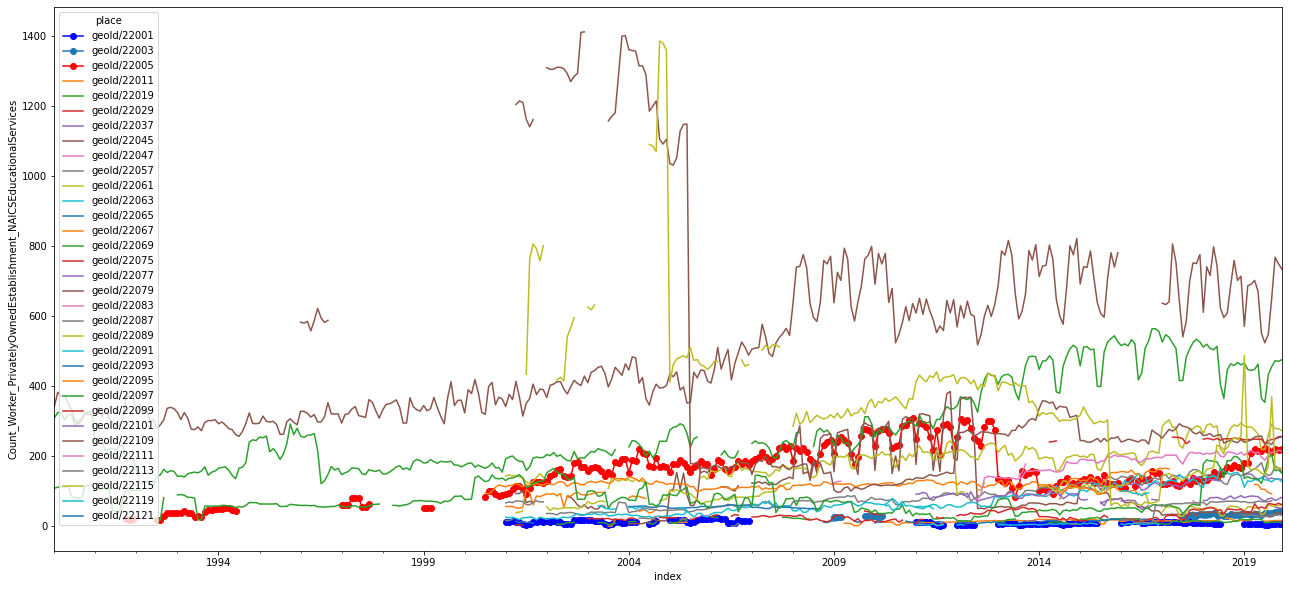

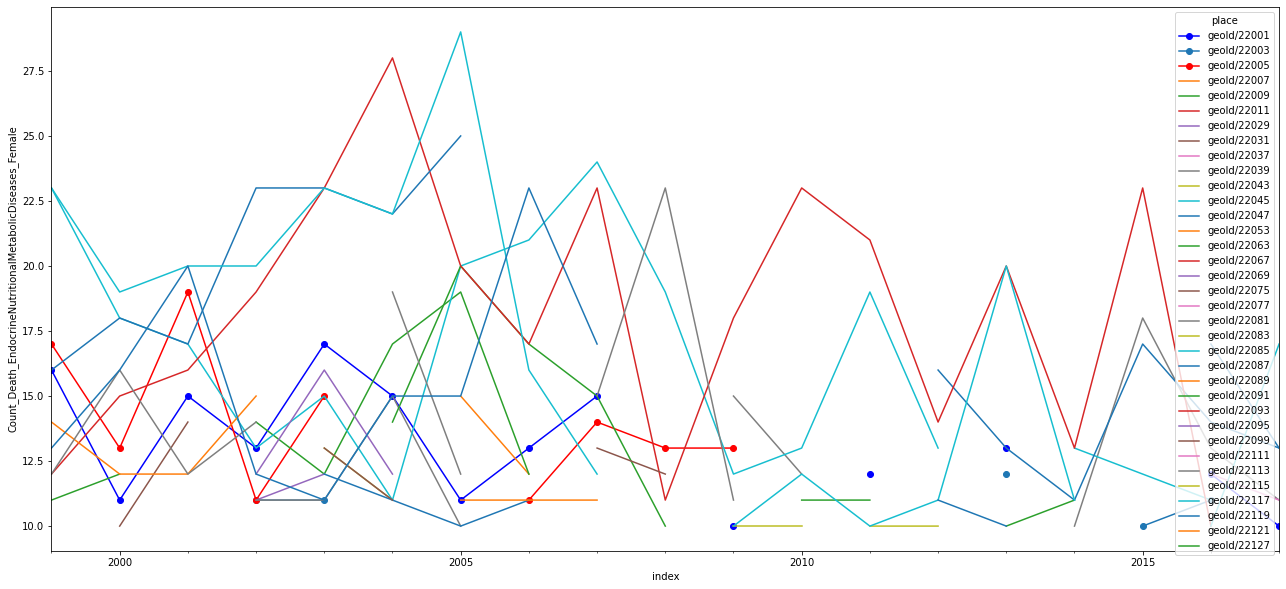

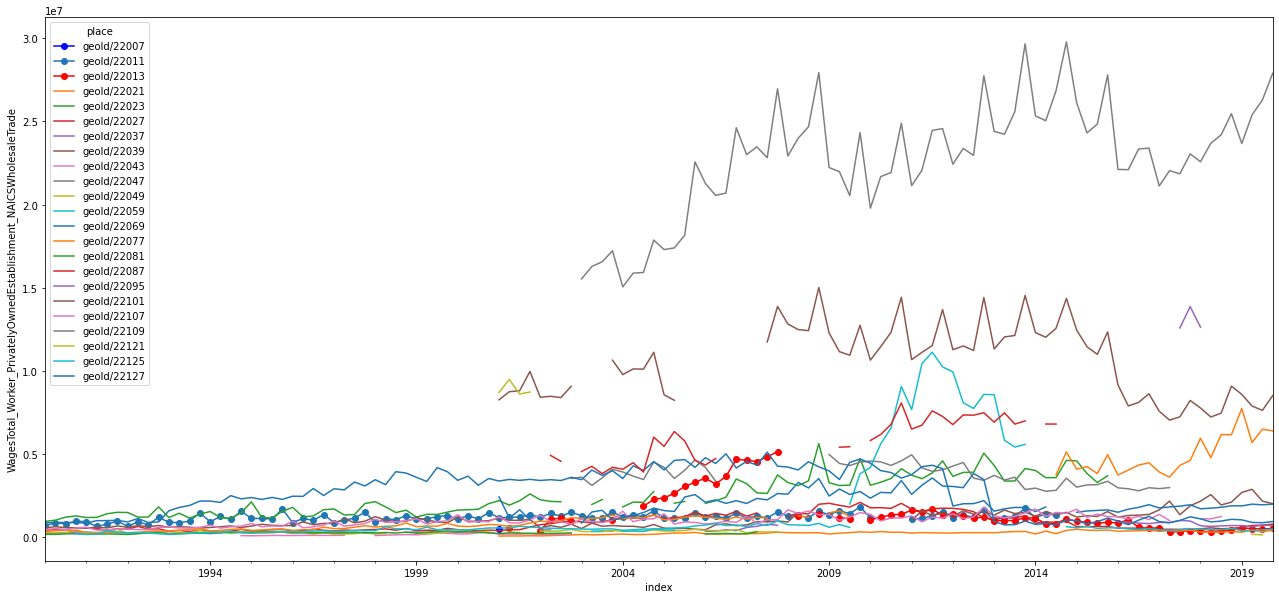

In [34]:
_PLACE = "geoId/22"

# Set the second value to True if you want to plot data for the sampled statistical variable:
random_stats = select_random_statvars(300, True, False)
print("number of valid samples: " , len(random_stats), random_stats)

# Looking into multiple imputation methods for sampled statistical varibales:

How we can measure how close are the imputed values?
Let's think about this question before we move on to the next step of this tutorial. 

In the sampling step, we made sure to sample statistical variables that have columns with both missing values and without any. 
In this step, we're going to utilize the columns that have no missing values. We can artificially remove some of the dates and use the imputation methods to fill them. Then one can compute the accuracy of each imputation method. In this notebook we R2 score $\in [-\infty , 1]$. The table is sorted by R2 values for each method. Higher R2 scores denote higher accuracy imputation. 

In [110]:
_METHODS = ["Mean", "Median", "Spline_d1", "Spline_d2", "Spline_d3", "Spline_d4", "Time", "Spline_d5", "InterpolateLinear", "Pchip", "Krogh", "InterpolateAkima"]

import warnings; warnings.simplefilter('ignore')
scores = artificial_score_generator(random_stats)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
scores

,method,Average of 20 rounds for Count_Death_CertainInfectiousParasiticDiseases_Female.,Average of 20 rounds for WagesTotal_Worker_NAICSInformation.,Average of 20 rounds for Count_Establishment_PrivatelyOwnedEstablishment_NAICSProfessionalScientificTechnicalServices.,Average of 20 rounds for Count_Worker_PrivatelyOwnedEstablishment_NAICSEducationalServices.,Average of 20 rounds for Count_Death_EndocrineNutritionalMetabolicDiseases_Female.,Average of 20 rounds for WagesTotal_Worker_PrivatelyOwnedEstablishment_NAICSWholesaleTrade.
0,Time,0.75,0.94,0.99,0.98,0.84,0.96
1,InterpolateLinear,0.75,0.94,0.99,0.98,0.84,0.96
2,Mean,0.74,0.80,0.80,0.80,0.78,0.80
3,Median,0.73,0.79,0.78,0.79,0.77,0.78
4,Spline_d1,0.72,0.93,0.99,0.98,0.83,0.96
5,Pchip,0.59,0.92,0.99,0.98,0.81,0.95
6,Spline_d2,-0.61,0.88,0.98,0.91,0.51,0.94
7,InterpolateAkima,-13.47,-21.06,-17.80,-19.21,-19.97,-17.29
8,Spline_d5,-101.00,-2.65,-101.00,-101.00,-101.00,-19.59
9,Spline_d3,-101.00,-45.50,-101.00,-101.00,-101.00,0.72


## Sampling function:

We use  **`build_time_series_dataframe`** to access the data for each sampled statistical variable. The function input is a the total sampled statistical variables and a boolean flag for plot/not plot the sampled statistical variables. To avoid value error for statistical varibles with no data for our selected place we use try/except. We filter the statistical variables that has greater than $threshold = 4$ columns with missing values and columns with no missing values. Also, the returned statistical variables have more than $threshold = 4$ data points each.


In [53]:
def select_random_statvars(sample_size, plot_flag, log_p):
  prov_query = f'SELECT distinct id FROM `google.com:datcom-store-dev.dc_v3_clustered.Instance` WHERE type = "StatisticalVariable"'
  prov = client.query(prov_query).to_dataframe()

  chosen_idx = np.random.choice(len(prov.index), replace=False, size=sample_size)
  df_trimmed = prov.iloc[chosen_idx]
  allstatvars = set(df_trimmed['id'])

  pltstats =[]

  # Comment the following line if you want to include all statistical variables:
  allstatvars = [x for x in allstatvars if not (x.startswith("dc/"))]

  geoids = (dc.get_places_in([_PLACE], "County"))[_PLACE]

  for statvar in allstatvars:
    try:
      data = dcpd.build_time_series_dataframe(geoids, statvar)
      data = data.transpose()
      data.reset_index(level=0, inplace=True)

      notNaColumns = data.columns[data.notna().all()].tolist()
      naColumns = data.columns[data.isnull().any()].tolist()
      data['index'] = pd.to_datetime(data['index'])
      
      threshold = 4
      if (len(naColumns) > threshold and len(notNaColumns)> threshold and data.size> threshold):
        if (plot_flag):
          data.set_index('index', inplace=True)
          plt = data[naColumns].plot(style=['bo-', 'o-', 'ro-'], figsize=(22, 10));
          plt.set_ylabel(statvar)
        pltstats.append(statvar)
    except ValueError as e:
      if (log_p):
        print(statvar, ': No data for', _PLACE)
      
  return pltstats

The **`artificial_score_generator`** retrieve data using **`build_time_series_dataframe`** for each statistical variables. Then, it calls the **`multiple_rounds_score_validation(data, rounds, statistical_variable)`** over (set to 20) rounds.

In each round, the **`one_round_cross_validation()`** removes random points and impute the *same* missing points with all possible methods that we defined earlier. Note that we want to compare the R2 scores of different imputation methods and it's crucial to use the same set of missing points for all of them. 

Also, to generate a normalized result, we repeat this process with different set of removed points and the **`multiple_rounds_score_validation`** function returns the average of R2 score values for each method. 

The reported R2 score is an average over multiple *independent* sampling and imputation for each statistical variable.

You can learn more about R2 score in [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). In short:

$$ R^2 = 1- \frac{\sum{(y_i - f_i)^2}}{{\sum{(y_i - mean)^2}}} = 1- \frac{\sum{(err)^2}}{{\sum{(y_i - mean)^2}}} $$

where $y_i$s are the actual values and $f_i$ are the imputed ones. $mean = \frac{1}{n} \sum{y_i} $.

In [109]:
def artificial_score_generator(rand_st):
  if (len(rand_st) < 1):
    print("run select_random_statvars again")
    return

  geoids = (dc.get_places_in([_PLACE], "County"))[_PLACE]
  all_scores = pd.DataFrame()
  i = -1
  for sv in rand_st:
    i += 1
    data = dcpd.build_time_series_dataframe(geoids, sv).transpose()
    data.reset_index(level=0, inplace=True)
    data['index'] = pd.to_datetime(data['index'])
    data.set_index('index', inplace=True)

    current_scores = multiple_rounds_cross_validation(data, 20, sv)
    current_scores.iloc[:, 1:2] = current_scores.iloc[:, 1:2].apply(lambda x: [y if y > -100 else -101 for y in x])
    if i > 0:
      all_scores = all_scores.merge(current_scores, on='method', how='left')
    else:
      all_scores = current_scores
    
  return all_scores 

In [104]:
import warnings

def multiple_rounds_cross_validation(df, rounds, stvar):
  notNaColumns = df.columns[df.notna().all()].tolist()
  multiple_rsquared_values = one_round_cross_validation(df, stvar)
  cols = multiple_rsquared_values.columns.difference(['method'])
  for round in range(rounds-1):
    multiple_rsquared_values[cols] = multiple_rsquared_values[cols].add(one_round_cross_validation(df, stvar)[cols])
    
  multiple_rsquared_values[cols] = multiple_rsquared_values[cols]/rounds
  ave = 'Average of %s rounds for %s.'%(rounds, stvar)
  multiple_rsquared_values[ave]=multiple_rsquared_values.mean(axis=1,skipna=True)
  multiple_rsquared_values.sort_values(by=ave, inplace = True, ascending=False)
  return multiple_rsquared_values[['method',ave]].round(3) 

def one_round_cross_validation(df, sv):
  rsquared_df = pd.DataFrame({'method': pd.Series(_METHODS)})
  notNaColumns = df.columns[df.notna().all()].tolist()
  df = df[notNaColumns]

  # Make a copy of each column and randomly delete values from original columns:
  for col in notNaColumns:
    df[col+"_ref"] = df[col].copy()
    df[col] = df[col].sample(frac=0.8)

  for col in notNaColumns:
    _FillwithX(df, col, sv)
    result = []
    # scoring the result and see which is better
    for m in _METHODS:
      r2 = -100
      try:
        r2 = r2_score(df[col+'_ref'], df["Fill"+m+"_"+col])
      except ValueError as e:
        warnings.warn("r2 returns large negative value for %s :" %m)
      result += [(m, r2)]
    
    rsquared_df["r2_"+col] = pd.DataFrame(result, columns=['Method', 'R_squared'])['R_squared'].copy()
    rsquared_df["r2_"+col] = pd.to_numeric(rsquared_df["r2_"+col])
  return rsquared_df 


def _FillwithX(df, geo, sv):
  for meth in _METHODS:
    method = "Fill"+meth+"_"+geo
    try:
        if (meth == 'Mean'):
          df[method] = df[geo].fillna(df[geo].mean())
        elif (meth == 'Median'):
          df[method] = df[geo].fillna(df[geo].median()).bfill()
        elif (meth == 'Spline_d1'):
          df[method] = df[geo].interpolate(method='spline', order=1).bfill()
        elif (meth == 'Spline_d2'):
          df[method] = df[geo].interpolate(method='spline', order=2).bfill()
        elif (meth == 'Spline_d3'):
          df[method] = df[geo].interpolate(method='spline', order=3).bfill()
        elif (meth == 'Spline_d4'):
          df[method] = df[geo].interpolate(method='spline', order=4).bfill()
        elif (meth == 'Spline_d5'):
          df[method] = df[geo].interpolate(method='spline', order=5).bfill()
        elif (meth == 'InterpolateLinear'):
          df[method] = df[geo].interpolate(method='linear').bfill()
        elif (meth == 'Time'):
          df[method] = df[geo].interpolate(method='time').bfill()
        elif (meth == 'InterpolateAkima'):
          df[method] = df[geo].interpolate(method='akima', order=2).bfill()
        elif (meth == 'InterpolateSLinear'):
          df[method] = df[geo].interpolate(method='slinear').bfill()
        elif (meth == 'InterpolatePoly5'):
          df[method] = df[geo].interpolate(method='polynomial', order=2).bfill()
        elif (meth == 'InterpolatePoly7'):
          df[method] = df[geo].interpolate(method='polynomial', order=7).bfill()
        elif (meth == 'Krogh'):
          df[method] = df[geo].interpolate(method='krogh').bfill()
        elif (meth == 'Pchip'):
          df[method] = df[geo].interpolate(method='pchip').bfill()
    except ValueError as e:
        print(meth, "imputation raised error for ", sv, " filled missing value with zero instead!")
        df[method] = df[geo].fillna(0, inplace=True)  
  return df